In [1]:
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
from dataloader import WHU_bldg
from Model import Unet
from engine import train_one_epoch

In [2]:
# HYPERPARAMETERS

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:' , device)

BATCH_SIZE = 8
EPOCHS = 30
lr = 0.001
out_size = 386

device: cuda


In [3]:
def unnormalize(tensor):
    
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225] 
    mean = torch.tensor(mean).reshape(-1, 1, 1)
    std = torch.tensor(std).reshape(-1, 1, 1)
    tensor = tensor * std + mean
    return tensor

In [4]:
dataset_dir = "/dataset/deepglobe-2018-road-extraction"

transform_rgb = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float32),  # Converts the tensor to float and scales to [0.0, 1.0]
    transforms.Resize((512 , 512)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example normalization
])

transform_grey = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((out_size, out_size), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ConvertImageDtype(torch.float32)  # Ensures masks are also floats if needed for specific loss calculations
])


In [5]:
train = WHU_bldg(parent_dir = "dataset" , set = "train" , transform_rgb= transform_rgb , transform_grey = transform_grey)
val = WHU_bldg(parent_dir = "dataset" , set = "val" , transform_rgb= transform_rgb , transform_grey = transform_grey)
test = WHU_bldg(parent_dir = "dataset" , set = "test" , transform_rgb= transform_rgb , transform_grey = transform_grey)

Display a sample

In [6]:
image , mask = train[10]
image = unnormalize(image)

image = image.permute(1 , 2, 0).numpy()
mask = mask.squeeze().numpy()
image.shape , mask.shape

((512, 512, 3), (386, 386))

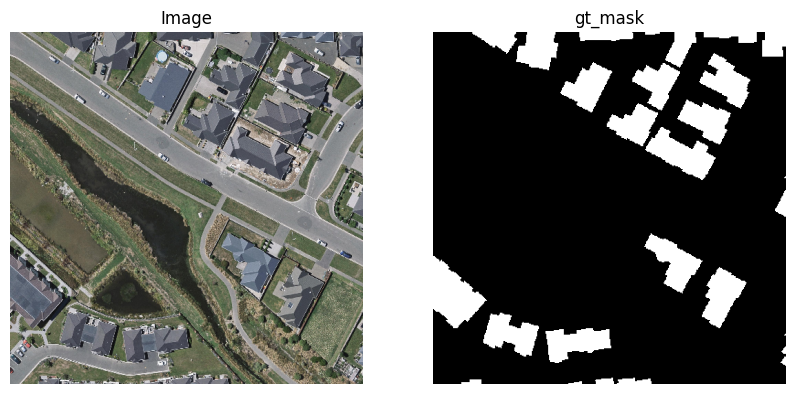

In [7]:
plt.figure(figsize=(10,5))

plt.subplot(1 , 2 , 1)
plt.imshow(image)
plt.title('Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask , cmap = 'gray')
plt.title('gt_mask')
plt.axis('off')

plt.show()

In [8]:
print(mask)

[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
train_loader = DataLoader(dataset = train , batch_size = BATCH_SIZE , shuffle= True)
val_loader = DataLoader(dataset = val , batch_size = BATCH_SIZE , shuffle = True)
test_loader = DataLoader(dataset = test , shuffle = False)

len(train_loader) , len(val_loader) # batches

(592, 130)

In [10]:
model = Unet().to(device)

summary(model , input_size=( 3 , 512 , 512))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 510, 510]              84
              ReLU-2          [-1, 3, 510, 510]               0
            Conv2d-3         [-1, 64, 508, 508]           1,792
              ReLU-4         [-1, 64, 508, 508]               0
       BatchNorm2d-5         [-1, 64, 508, 508]             128
         MaxPool2d-6         [-1, 64, 254, 254]               0
            Conv2d-7        [-1, 128, 252, 252]          73,856
              ReLU-8        [-1, 128, 252, 252]               0
         MaxPool2d-9        [-1, 128, 126, 126]               0
           Conv2d-10        [-1, 256, 124, 124]         295,168
             ReLU-11        [-1, 256, 124, 124]               0
        MaxPool2d-12          [-1, 256, 62, 62]               0
           Conv2d-13          [-1, 512, 60, 60]       1,180,160
             ReLU-14          [-1, 512,

In [ ]:
metrics = train_one_epoch(model = model , 
                          train_loader = train_loader , 
                          val_loader = val_loader , 
                          epochs  = EPOCHS , 
                          lr = lr , 
                          scheduler = 'exponential' , 
                          out_dir = 'weights/best_checkpoint.pth' , 
                          device = device)

In [11]:
checkpoint = torch.load("weights/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [30]:
test_iter = iter(test_loader)
first_batch = next(test_iter)
images , labels  = first_batch
images = images.to(device)
with torch.no_grad():
    pred = model(images)

In [23]:
import cv2
import numpy as np

# Assuming `model_output` is the (324, 324) output from your model
model_output_resized = cv2.resize(pred, (512, 512), interpolation=cv2.INTER_LINEAR)

# If model_output is a probability map, you might want to threshold it to get a binary mask
thresholded_output = (model_output_resized > 0.5).astype(np.uint8)
